# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages, plotGridSearch
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Signaling data

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

0/438 peptides were not found in the proteome.
438


In [4]:
X

,Protein,Sequence,UniprotAcc,Position,BioReps,r2_Std,Gene,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",TAEPDyGALYE,P19174,Y771-p,1,N/A,PLCG1,0.146277,-0.452506,-0.212346,-0.322889,0.265081,0.025052,0.304444,0.039775,0.132145,0.074967
1,26S proteasome regulatory subunit 4,DKKKKyEPPVP,P62191,Y25-p,1,N/A,PSMC1,-0.108045,-0.476332,-0.321637,-0.239781,0.126419,0.274226,0.243800,0.210842,0.326859,-0.036352
2,40S ribosomal protein S27,QSPNSyFMDVK,P42677,Y31-p,1,N/A,RPS27,-0.086052,-0.094996,-0.173403,-0.185023,-0.079203,0.107230,-0.124472,0.160896,0.230457,0.244567
3,40S ribosomal protein S3,VRRACyGVLRF,P23396,Y120-p,1,N/A,RPS3,0.056686,0.139572,-0.020027,0.035964,-0.440089,-0.006117,-0.069619,0.003662,0.209473,0.090494
4,40S ribosomal protein SA,LTEASyVNLPT,P08865,Y139-p,1,N/A,RPSA,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,Tyrosine-protein phosphatase non-receptor type...,PSFSEyASVQV,P78324,Y496-p,1,N/A,SIRPA,0.959928,-0.907931,-0.033116,-0.481825,0.436319,-0.163870,0.024939,0.111514,0.109740,-0.055698
324,Uncharacterized protein C11orf52,HLENAtEYATL,Q96A22,T101-p,1,N/A,C11orf52,0.444559,-0.611138,0.181484,-0.460965,0.458726,-0.214453,-0.020277,-0.018105,0.043728,0.196441
325,Uncharacterized protein C6orf132,PGSADyGFAPA,Q5T0Z8,Y1142-p,1,N/A,C6orf132,0.919313,0.008038,-0.628323,-0.065899,-0.067763,0.441085,-0.160495,-0.329553,-0.004565,-0.111838
326,Uncharacterized protein KIAA1671,RIEPRyDIVHA,Q9BY89,Y733-p,1,N/A,KIAA1671,0.179742,-0.054978,-0.171872,0.065117,0.023957,0.160009,0.114581,-0.237162,0.088879,-0.168274


## Cell Phenotypes

### Cell Viability

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [6]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [7]:
v_ae

,Lines,Treatment,Viability
0,WT,A/E,4.403463
1,KO,A/E,1.661781
2,KD,A/E,2.430256
3,KI,A/E,3.194731
4,Y634F,A/E,3.000097
5,Y643F,A/E,3.051070
6,Y698F,A/E,3.819585
7,Y726F,A/E,3.599395
8,Y750F,A/E,3.680701
9,Y821F,A/E,2.955662


### Cell Death

In [8]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [9]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]

cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [10]:
cd_ae

,Lines,Treatment,Apoptosis
0,WT,A/E,3.691883
1,KO,A/E,7.664414
2,KD,A/E,4.564952
3,KI,A/E,4.377763
4,Y634F,A/E,3.669173
5,Y643F,A/E,5.044015
6,Y698F,A/E,3.803003
7,Y726F,A/E,3.277052
8,Y750F,A/E,3.320825
9,Y821F,A/E,2.643537


### Cell Migration

In [11]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [12]:
ftp = 12
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [13]:
m_ae

,Lines,Treatment,Migration
0,WT,A/E,79.708804
1,KO,A/E,59.678504
2,KD,A/E,59.351836
3,KI,A/E,78.931115
4,Y634F,A/E,77.178136
5,Y643F,A/E,79.026550
6,Y698F,A/E,82.495564
7,Y726F,A/E,78.351154
8,Y750F,A/E,73.529358
9,Y821F,A/E,69.620674


### PCA Analysis

In [14]:
from sklearn.decomposition import PCA

In [15]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"]], axis=1)

In [16]:
y_fc = pd.concat([y_ae.iloc[:, :2], y_ae.iloc[:, 2:] / y_e.iloc[:, 2:]], axis=1)
y_fc["Treatment"] = "A fold-change to E"

In [17]:
y_fc

,Lines,Treatment,Viability,Apoptosis,Migration
0,WT,A fold-change to E,1.503950,0.357265,0.994102
1,KO,A fold-change to E,0.954029,1.124600,0.874078
2,KD,A fold-change to E,1.040835,0.834264,0.970822
3,KI,A fold-change to E,1.103106,0.829127,1.130721
4,Y634F,A fold-change to E,1.109425,0.721999,1.100216
5,Y643F,A fold-change to E,1.197808,0.867798,1.092991
6,Y698F,A fold-change to E,1.281392,0.778741,1.218097
7,Y726F,A fold-change to E,1.247131,0.649464,1.213338
8,Y750F,A fold-change to E,1.208811,0.923612,1.092641
9,Y821F,A fold-change to E,1.077344,0.506015,1.090899


In [18]:
c = 3
pp = PCA(n_components=c)

dScor_ = pp.fit_transform(y_fc.iloc[:, 2:].values)
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, y_fc, c, ["Lines", "Treatment"], "Phenotype")
varExp = np.round(pp.explained_variance_ratio_, 2)

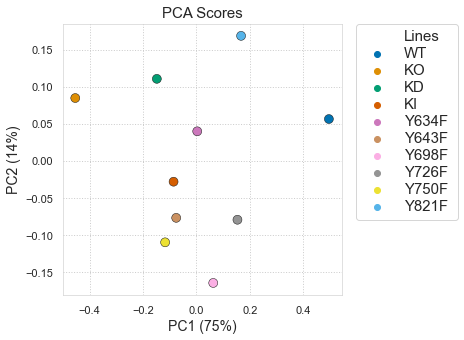

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Lines", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);

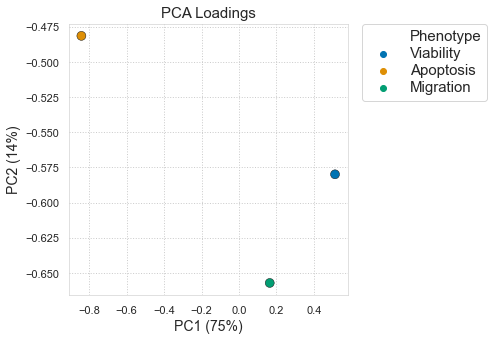

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Phenotype", ax=ax, s=80, markers=["o", "X", "d"], **{'linewidth':.5, 'edgecolor':"k"})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15)
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [ ]:
y = y_fc.drop("Treatment", axis=1).set_index("Lines")

# Co-clustering and PLSR model

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [24]:
distance_method = "PAM250"
ncl = 4
GMMweight = 0

MSC = MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method, n_runs=3).fit(d, y)
centers = MSC.transform(d)

run:  0
run:  1
run:  2


In [25]:
centers

,0,1,2,3
0,0.099324,0.152754,0.164116,0.304857
1,-0.203185,-0.204006,-0.005027,-0.195382
2,-0.157174,-0.235165,-0.213331,-0.162576
3,-0.142060,-0.045688,-0.048381,-0.155113
4,-0.062662,0.061320,-0.066610,0.055827
5,0.080275,0.089070,0.069558,0.033159
6,0.129815,0.132248,0.049870,0.139465
7,0.061051,0.025606,0.009246,0.038966
8,0.130215,-0.010044,-0.052496,-0.037770
9,0.064401,0.033905,0.093055,-0.021432


#### R2Y/Q2Y

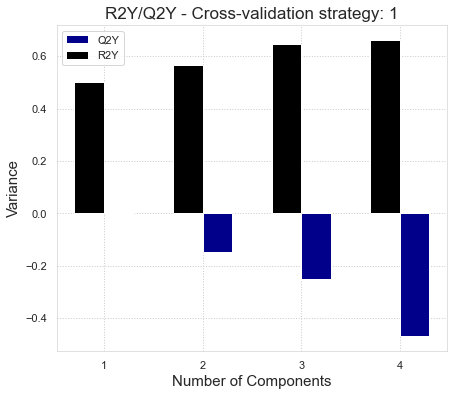

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plsr = PLSRegression(n_components=2)
plotR2YQ2Y(ax, plsr, centers, y, 1, 5)
fig.savefig("RQ2Y_CV1.png")

#### Measured vs Predicted

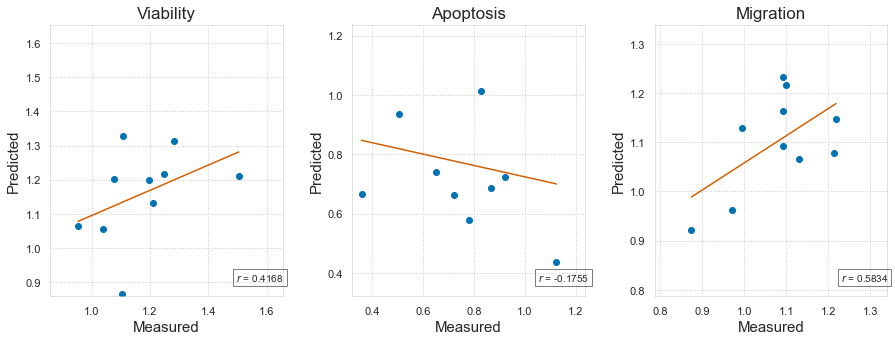

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plotMeasuredVsPredicted(ax, plsr, centers, y)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
fig.savefig("MeasuredVsPredicted_CV1.png")

#### Scores & Loadings

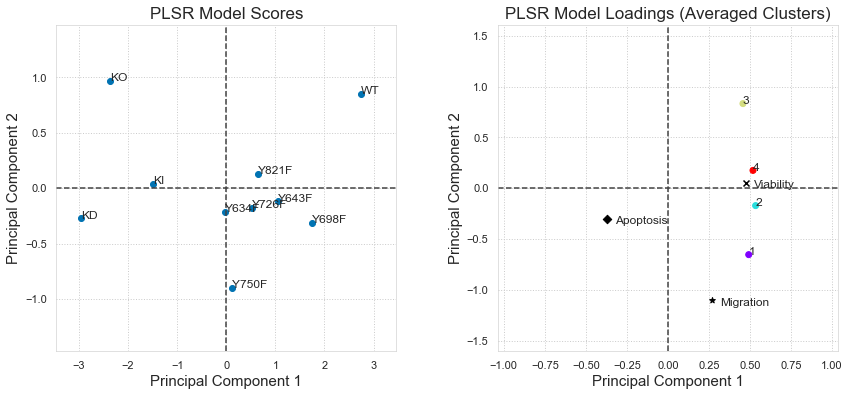

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ncl, all_lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# fig.savefig("ScoresLoadings_CV1.pdf")

In [29]:
cl = MSC.clustermembers(X.T)

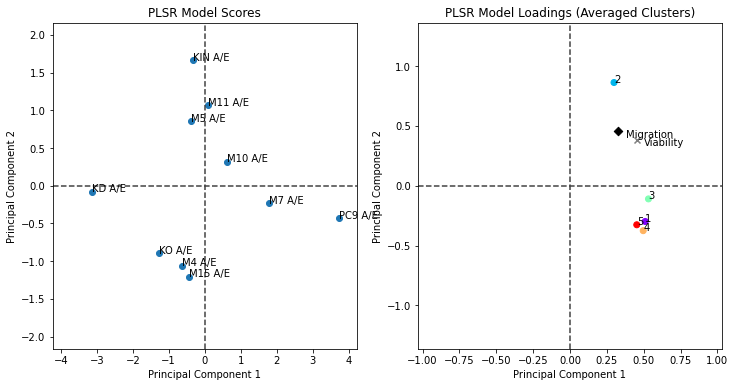

In [ ]:
create_download_link(cl, "clusters")

In [18]:
cl

#### Cluster Averages

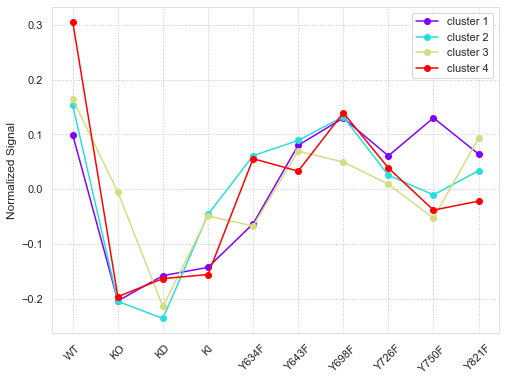

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, MSC.transform(d).T, all_lines)
# fig.savefig("ClusterAverages_CV1.pdf")

In [ ]:
raise SystemExit

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [20]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

run:  0
iter:  0
-116964.70503154535
iter:  1
-221090.00655370436
iter:  2
-249099.62641161025
iter:  3
-268632.86734182405
iter:  4
-280498.9601184011
iter:  5
-288039.3453512016
iter:  6
-294901.2929692973
iter:  7
-297904.6543329809
iter:  8
-307988.07888218894
iter:  9
-313880.7613147206
iter:  10
-315980.76849088294
iter:  11
-318036.6132231763
iter:  12
-319128.3179790854
iter:  13
-319854.1221201015
iter:  14
-319775.4974009373
run:  1
iter:  0
-127684.57542166158
iter:  1
-284547.98474790406
iter:  2
-311495.4716741453
iter:  3
-327902.63183678454
iter:  4
-333809.8492422208
iter:  5
-340929.83092018147
iter:  6
-343494.3534092292
iter:  7
-344270.3473634831
run:  2
iter:  0
-146018.30931411372
iter:  1
-289424.41643421137
iter:  2
-311494.4176654844
iter:  3
-326554.700223324
iter:  4
-328680.6105453185
iter:  5
-330710.3982792979
iter:  6
-330939.95048841066
run:  3
iter:  0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
iter:  1
-138978.3091266672
iter:  2
-2959

#### R2Y/Q2Y

In [21]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=ncl+1)

#### GridSearch

Run:

In [22]:
# scores = MSclusPLSR_tuning(d, i, y, "Binomial")

# scores = pd.DataFrame(scores)
# hp = scores.sort_values(by="mean_test_scores", ascending=False)
# hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))
# hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
# hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

Import:

In [23]:
gs = pd.read_csv("msresist/data/Model/20200320-GridSearch_pam250_CVWC_wPC9.csv")

In [24]:
gs[gs["#Components"] == 2].head(10)

,Unnamed: 0,Ranking,#Clusters,#Components,GMMweights,mean_test_scores,mean_train_scores
9,253,10,11,2,5.0,-29.668806,-6.994764
26,377,27,15,2,1.0,-37.047167,-5.660698
30,385,31,15,2,10.0,-37.527371,-3.946341
32,61,33,4,2,5.0,-38.230793,-22.190356
37,165,38,8,2,20.0,-42.491368,-12.261999
40,321,41,13,2,10.0,-43.013695,-6.242054
41,325,42,13,2,20.0,-43.323571,-6.792835
42,189,43,9,2,5.0,-43.595687,-7.462485
44,381,45,15,2,5.0,-43.859577,-5.957370
45,133,46,7,2,20.0,-43.975031,-11.684045


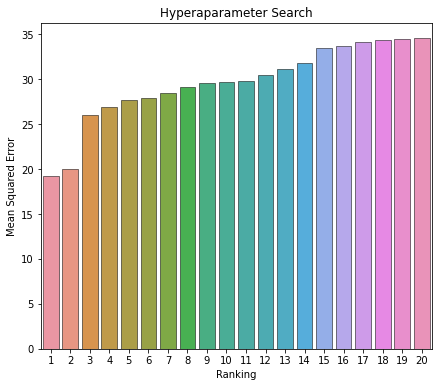

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotGridSearch(ax, gs)

#### Measured vs Predicted

run:  0
iter:  0
-110616.1514556834
iter:  1
-278849.75003877905
iter:  2
-292202.2812114603
iter:  3
-302312.51303352654
iter:  4
-308482.8579175765
iter:  5
-313062.42033312935
iter:  6
-322003.87504935387
iter:  7
-329914.9107554899
iter:  8
-333966.3855033693
iter:  9
-333587.3955365279
iter:  10
-333990.95475848304
iter:  11
-334448.7151807163
iter:  12
-335144.54029891413
iter:  13
-335531.70199622086
iter:  14
-335110.76235351816
iter:  15
-335411.3200999633
run:  1
iter:  0
-112018.86220800327
iter:  1
-268769.25512169336
iter:  2
-276837.5861086529
iter:  3
-280968.6563451515
iter:  4
-282166.07581803115
iter:  5
-281523.6148785602
iter:  6
-281400.5287916767
run:  2
iter:  0
-94259.60661596406
iter:  1
-231461.6892806189
iter:  2
-279571.13504818664
iter:  3
-297885.5357822591
iter:  4
-302111.17032851954
iter:  5
-300425.3015438723
iter:  6
-300417.1640512093
run:  3
iter:  0
-158767.9442331598
iter:  1
-307474.8158450109
iter:  2
-339828.4089482309
iter:  3
-355797.41243647

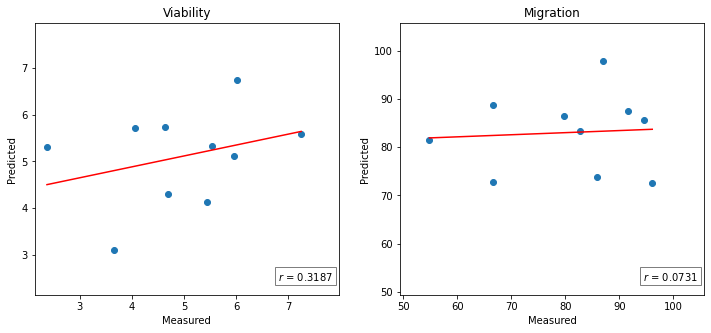

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
plotMeasuredVsPredicted(ax, CoCl_plsr, d, y)

#### Scores & Loadings

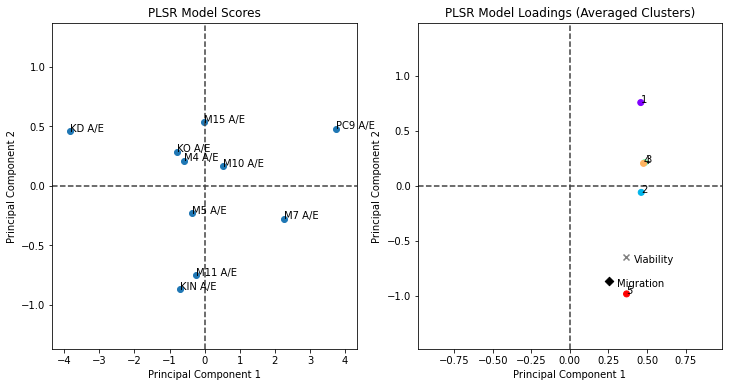

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, all_lines, 2)

In [28]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

#### Cluster Averages

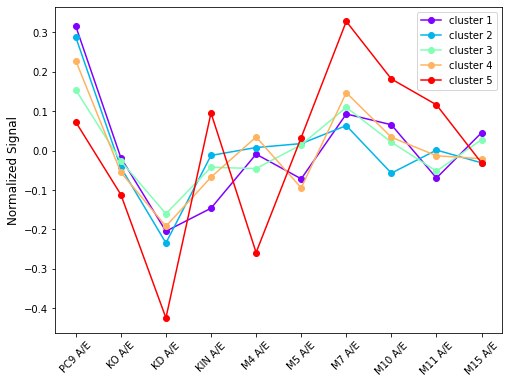

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers.T, all_lines)